In [8]:
#%matplotlib notebook
%matplotlib inline
import sys
sys.path.append("..")
import matplotlib.pyplot as plt
import os
import numpy as np
import json
import argparse
import torch
from torch.optim import lr_scheduler
from tqdm import tqdm
from data_loader import data_loaders as module_data
from model import loss as module_loss
from model import metric as module_metric
from model import model as module_arch
from trainer import Trainer
from utils import Logger
from utils import util
from utils import torchsummary
from utils import viewTraining
from utils import lr_finder
from utils import classActivationMap
import importlib
import math
import torchvision
from torch.nn import functional as F
from torch import topk
import skimage.transform
import jupyter
from IPython import display
from ipywidgets import *
print("Modules loaded")

importlib.reload(module_data) #load recent changes to data_loaders.py
importlib.reload(module_arch)
importlib.reload(module_loss)
importlib.reload(module_metric)
importlib.reload(util)
importlib.reload(viewTraining)
importlib.reload(lr_finder)
importlib.reload(classActivationMap)
print("Reload complete")

print("GPUs available: " + str(torch.cuda.device_count()))
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"




Modules loaded
Reload complete
GPUs available: 1


Total number of training images = 18746
torch.Size([256, 3, 224, 224])


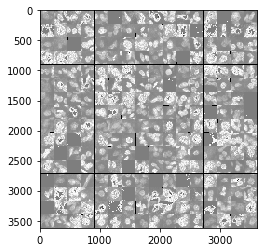

In [11]:
#This function gets the parameters from the config.json file 
def get_instance(module, name, config, *args):
    return getattr(module, config[name]['type'])(*args, **config[name]['args'])

data_loader = get_instance(module_data, 'data_loader', config) #looks in data_loader/data_loaders.py for 'MNISTDataLoader'
print("Total number of training images = " + str(data_loader.dataset.data_len))
valid_data_loader = data_loader.split_validation() #allocate some images as validation

normalized = False
#util.visualizeBatch(data_loader, normalized) 
imgs = next(iter(data_loader))
print(imgs[0].shape)
grid = torchvision.utils.make_grid(imgs[0], nrow=16, padding=2, normalize=True, range=None, scale_each=False, pad_value=0)

plt.imshow(grid.numpy().transpose((1, 2, 0)))

In [9]:
#This function gets the parameters from the config.json file 
def get_instance(module, name, config, *args):
    return getattr(module, config[name]['type'])(*args, **config[name]['args'])

def set_instance(module, name, config, *args):
    setattr(module, config[name]['type'])(*args, **config[name]['args'])

def main(config, resume):
    train_logger = Logger() #uses entries to store training performance metrics
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # setup data_loader instances
    data_loader = get_instance(module_data, 'data_loader', config) #looks in data_loader/data_loaders.py for 'MNISTDataLoader'
    print("Total number of training images = " + str(data_loader.dataset.data_len))
    valid_data_loader = data_loader.split_validation() #allocate some images as validation

    # build model architecture
    model = get_instance(module_arch, 'arch', config) #looks in the model/model.py for 'MnistModel', as specified by config
    print(model)
    #torchsummary.summary(model, (1,7,32,32))
    torchsummary.summary(model, (3,224,224))
    
    if torch.cuda.is_available():
        print("Using GPU: " + torch.cuda.get_device_name(0))
    else:
        print("Using CPU to train")
    
    
    # get function handles of loss and metrics
    loss = getattr(module_loss, config['loss']) #looks in model/loss.py for criterion function specified in config
    criterion = loss(data_loader.dataset.weight.to(device)) # for imbalanced datasets
    metrics = [getattr(module_metric, met) for met in config['metrics']] #get all the metrics in model/metrics.py - default is accuracy and top 3 accuracy

    # build optimizer, learning rate scheduler. delete every lines containing lr_scheduler for disabling scheduler
    trainable_params = filter(lambda p: p.requires_grad, model.parameters()) #Number of training params
    optimizer = get_instance(torch.optim, 'optimizer', config, trainable_params)
    lr_scheduler = get_instance(torch.optim.lr_scheduler, 'lr_scheduler', config, optimizer)

    
    trainer = Trainer(model, criterion, metrics, optimizer,
                      resume=resume, #choose a previous epoch to start training from
                      config=config,
                      data_loader=data_loader,
                      valid_data_loader=valid_data_loader,
                      lr_scheduler=lr_scheduler,
                      train_logger=train_logger)
    
    
    findLR = False
    if findLR:
        #set lr = 1e-7 in config file 
        device_lr = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        lr_finder_training = lr_finder.LRFinder(model, optimizer, criterion, device=device_lr)
        lr_finder_training.range_test(data_loader, end_lr=1, num_iter=100, val_loader = valid_data_loader)
        lr_finder_training.plot(skip_start = 10, skip_end=5)
        # trim the first 10 and last 5 iteration from calculating loss (num_iter > skip_start + skip_end)
    else:
        trainer.train()
        a=1
    
 

In [10]:
config_file = '../configs/config_hdf5.json'

# load config file
with open(config_file) as handle:
    config = json.load(handle)
# setting path to save trained models and log files
path = os.path.join(config['trainer']['save_dir'], config['name'])

In [12]:
# Train the network
main(config, None)

Total number of training images = 18746
pretrainedModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
       

Trainable parameters: 10245
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      Batch

          Conv2d-125         [-1, 1024, 14, 14]         262,144
     BatchNorm2d-126         [-1, 1024, 14, 14]           2,048
          Conv2d-127         [-1, 1024, 14, 14]         524,288
     BatchNorm2d-128         [-1, 1024, 14, 14]           2,048
            ReLU-129         [-1, 1024, 14, 14]               0
      Bottleneck-130         [-1, 1024, 14, 14]               0
          Conv2d-131          [-1, 256, 14, 14]         262,144
     BatchNorm2d-132          [-1, 256, 14, 14]             512
            ReLU-133          [-1, 256, 14, 14]               0
          Conv2d-134          [-1, 256, 14, 14]         589,824
     BatchNorm2d-135          [-1, 256, 14, 14]             512
            ReLU-136          [-1, 256, 14, 14]               0
          Conv2d-137         [-1, 1024, 14, 14]         262,144
     BatchNorm2d-138         [-1, 1024, 14, 14]           2,048
            ReLU-139         [-1, 1024, 14, 14]               0
      Bottleneck-140         [-1, 1024, 

            ReLU-253          [-1, 256, 14, 14]               0
          Conv2d-254          [-1, 256, 14, 14]         589,824
     BatchNorm2d-255          [-1, 256, 14, 14]             512
            ReLU-256          [-1, 256, 14, 14]               0
          Conv2d-257         [-1, 1024, 14, 14]         262,144
     BatchNorm2d-258         [-1, 1024, 14, 14]           2,048
            ReLU-259         [-1, 1024, 14, 14]               0
      Bottleneck-260         [-1, 1024, 14, 14]               0
          Conv2d-261          [-1, 256, 14, 14]         262,144
     BatchNorm2d-262          [-1, 256, 14, 14]             512
            ReLU-263          [-1, 256, 14, 14]               0
          Conv2d-264          [-1, 256, 14, 14]         589,824
     BatchNorm2d-265          [-1, 256, 14, 14]             512
            ReLU-266          [-1, 256, 14, 14]               0
          Conv2d-267         [-1, 1024, 14, 14]         262,144
     BatchNorm2d-268         [-1, 1024, 

          Conv2d-381          [-1, 256, 14, 14]         262,144
     BatchNorm2d-382          [-1, 256, 14, 14]             512
            ReLU-383          [-1, 256, 14, 14]               0
          Conv2d-384          [-1, 256, 14, 14]         589,824
     BatchNorm2d-385          [-1, 256, 14, 14]             512
            ReLU-386          [-1, 256, 14, 14]               0
          Conv2d-387         [-1, 1024, 14, 14]         262,144
     BatchNorm2d-388         [-1, 1024, 14, 14]           2,048
            ReLU-389         [-1, 1024, 14, 14]               0
      Bottleneck-390         [-1, 1024, 14, 14]               0
          Conv2d-391          [-1, 256, 14, 14]         262,144
     BatchNorm2d-392          [-1, 256, 14, 14]             512
            ReLU-393          [-1, 256, 14, 14]               0
          Conv2d-394          [-1, 256, 14, 14]         589,824
     BatchNorm2d-395          [-1, 256, 14, 14]             512
            ReLU-396          [-1, 256, 

          Conv2d-509           [-1, 2048, 7, 7]       1,048,576
     BatchNorm2d-510           [-1, 2048, 7, 7]           4,096
            ReLU-511           [-1, 2048, 7, 7]               0
      Bottleneck-512           [-1, 2048, 7, 7]               0
AdaptiveAvgPool2d-513           [-1, 2048, 1, 1]               0
          Linear-514                    [-1, 5]          10,245
          ResNet-515                    [-1, 5]               0
Total params: 58,154,053
Trainable params: 10,245
Non-trainable params: 58,143,808
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 606.58
Params size (MB): 221.84
Estimated Total Size (MB): 829.00
----------------------------------------------------------------
Using GPU: GeForce RTX 2080 Ti


    epoch          : 1
    loss           : 1.8884689628131806
    accuracy       : 0.5641534391534391
    f1             : 0.5102339280952624
    balanced_accuracy: 0.5820055414470258
    precision      : 0.5630709695627927
    recall         : 0.5641534391534391
    val_loss       : 0.8672789606181058
    val_accuracy   : 0.5783980555052518
    val_f1         : 0.5868285281685683
    val_balanced_accuracy: 0.623594677821454
    val_precision  : 0.6893006614156365
    val_recall     : 0.5783980555052518


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/CellTemplate/saved/pretrained_test\1022_154131\checkpoint-epoch1.pth ...
Saving current best: model_best.pth ...
    epoch          : 2
    loss           : 0.6124436216694968
    accuracy       : 0.7305022124590577
    f1             : 0.736146496456117
    balanced_accuracy: 0.7331715086170612
    precision      : 0.7740297792175437
    recall         : 0.7305022124590577
    val_loss       : 0.6291794939474626
    val_accuracy   : 0.6606839686707715
    val_f1         : 0.668978813993733
    val_balanced_accuracy: 0.7155749330735809
    val_precision  : 0.796420683612956
    val_recall     : 0.6606839686707715


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/CellTemplate/saved/pretrained_test\1022_154131\checkpoint-epoch2.pth ...
Saving current best: model_best.pth ...
    epoch          : 3
    loss           : 0.6028303139739566
    accuracy       : 0.739364843159486
    f1             : 0.7446646933674497
    balanced_accuracy: 0.7383989049277885
    precision      : 0.7852049976854899
    recall         : 0.739364843159486
    val_loss       : 0.5622349273074757
    val_accuracy   : 0.7414008737776168
    val_f1         : 0.7514489622108286
    val_balanced_accuracy: 0.7569007780074061
    val_precision  : 0.7883370345549565
    val_recall     : 0.7414008737776168


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/CellTemplate/saved/pretrained_test\1022_154131\checkpoint-epoch3.pth ...
Saving current best: model_best.pth ...
    epoch          : 4
    loss           : 0.6098605621428717
    accuracy       : 0.7354517038296801
    f1             : 0.7334842535944109
    balanced_accuracy: 0.7353685982045258
    precision      : 0.7859338461595813
    recall         : 0.7354517038296801
    val_loss       : 0.6696344614028931
    val_accuracy   : 0.7317562137812387
    val_f1         : 0.704794817986047
    val_balanced_accuracy: 0.7198895273366319
    val_precision  : 0.7914813740106829
    val_recall     : 0.7317562137812387


Model has not improved in -------------| 1 epochs


KeyboardInterrupt: 

skipped file: config.json


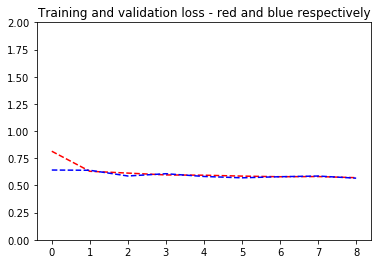

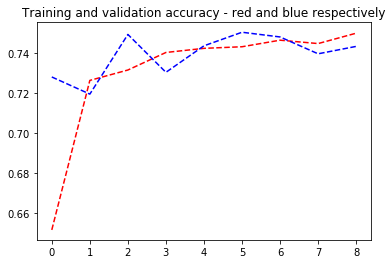

done


In [7]:
saved_dir = '../saved/pretrained_test/1022_150658'
config_saved_filename = os.path.join(saved_dir, "config.json")
#os.system('tensorboard --logdir ' + log_dir) cannot use with google VM without paying $$$
viewTraining.graphLoss(saved_dir, best=False) #imported from utils


print('done')

In [16]:
def main2(config, resume):
    # setup data_loader instances
    data_loader = get_instance(module_data, 'data_loader_test', config)
    '''
    
    data_loader = getattr(module_data, config['data_loader']['type'])(
        config['data_loader']['args']['data_dir'],
        batch_size=1,
        shuffle=False,
        validation_split=0.0,
        training=False,
        num_workers=2
    )
    '''
    # build model architecture
    model = get_instance(module_arch, 'arch', config)
    #print(model)
    print(torch.cuda.get_device_name(0))
    normalized = False

    
    # get function handles of loss and metrics
    loss_fn = getattr(module_loss, config['loss'])
    criterion = loss_fn(None)
    metric_fns = [getattr(module_metric, met) for met in config['metrics']]
    
    # load state dict
    checkpoint = torch.load(resume)
    state_dict = checkpoint['state_dict'] #dictionary of model parameters from saved file
    if config['n_gpu'] > 1:
        model = torch.nn.DataParallel(model)
    model.load_state_dict(state_dict) 
    
    # prepare model for testing
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval() #tells model to ignore dropout and batch normalization
    
    total_loss = 0.0
    total_metrics = torch.zeros(len(metric_fns))
    
    #classes = ('endothelium', 'pct', 'vasculature')
    classes = ('endothelium', 'pct')
    all_pred = []
    all_true = []
    all_softmax = []
    #hm_layers = {'final_layer': 'layer', 'fc_layer': 'fc_layer', 'conv_num': 17, 'fc_num': 3}
    
    #heatmapper = classActivationMap.CAMgenerator(hm_layers, config, model)
    #heatmapper.generateImage(num_images=10)
    
    with torch.no_grad(): #speed up calculations, unable to perform back propogation
        for i, (data, target) in enumerate(tqdm(data_loader)): #tqdm is a progress bar
            data, target = data.to(device), target.to(device)
            output = model(data)
            image = np.squeeze(data[0].cpu().data.numpy())
            label = np.squeeze(target[0].cpu().data.numpy())
            all_true.extend(target.cpu().data.numpy())
            all_pred.extend(np.argmax(output.cpu().data.numpy(), axis=1))
            
            #
            # save sample images, or do something with output here
            #
            
            
            if i < 2:
                m = torch.nn.Softmax(dim=0)
                print("prediction percentages")
                print(m(output.cpu()[0]))
                print(all_true[i])
                all_softmax.extend(m(output.cpu()))
                #util.visualizationOutGray(data, output, target, classes, normalized)
                a=1
                
                
                
            # computing loss, metrics on test set
            loss = criterion(output, target)
            batch_size = data.shape[0]
            total_loss += loss.item() * batch_size
            if output.is_cuda: output = output.cpu()
            if target.is_cuda: target = target.cpu()
            
            for i, metric in enumerate(metric_fns):
                total_metrics[i] += metric(output, target) * batch_size
        
        #plt.show()
        
    outputcsv = False
    if outputcsv:
        ids = data_loader.ids
        softmax = pd.DataFrame(all_softmax)
        frames = [ids, softmax]
        output_data= np.concatenate(frames, axis=1, join='outer')
        print(output_data.shape)
        
        
    n_samples = len(data_loader.sampler)
    print("num test images = " + str(n_samples))
    log = {'loss': total_loss / n_samples}
    log.update({met.__name__: total_metrics[i].item() / n_samples for i, met in enumerate(metric_fns)})
    for key in log:
        print("{} = {:.4f}".format(key, log[key]))
    #print(log)
    log['classes'] = classes
    log['test_targets'] = all_true
    log['test_predictions'] = all_pred
    print("My_metric is accuracy")
    util.plot_confusion_matrix(all_true, all_pred, classes=classes, normalize=False) 
    


In [17]:
#saved_dir = "saved/GroundTruth_cellData/0529_191042/"
resume = os.path.join(saved_dir, "model_best.pth")

print(os.path.isdir(saved_dir))
print(os.path.exists(resume))

#config = torch.load(saved_dir + "config.json")
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

True
True


  0%|          | 0/16 [00:00<?, ?it/s]

Tesla K80


/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
 31%|███▏      | 5/16 [00:00<00:02,  4.44it/s]

prediction percentages
tensor([0.6396, 0.3604])
0
prediction percentages
tensor([0.9989, 0.0011])
0


100%|██████████| 16/16 [00:00<00:00, 20.64it/s]

num test images = 1001
loss = 0.1587
my_metric = 0.9481
f1 = 0.9713
balanced_accuracy = 0.9502
precision = 0.9971
recall = 0.9481
My_metric is accuracy
Confusion matrix, without normalization
[[ 63   8]
 [ 44 886]]


<IPython.core.display.Javascript object>


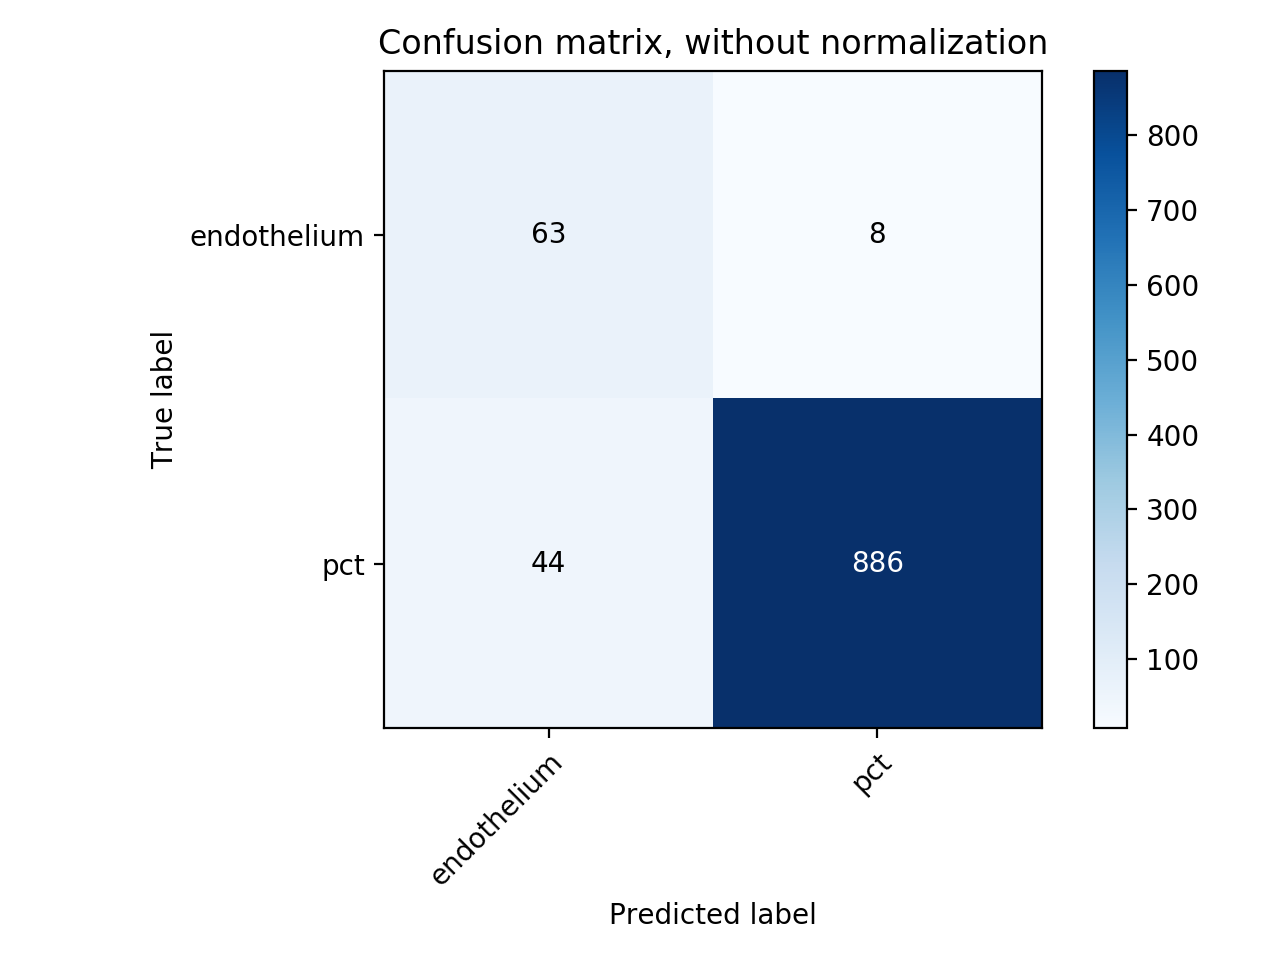

In [20]:
#Test
main2(config, resume)
